# Building an Image Model
In this example, we will repeat the procedure of fitting an ellipse to a sprial galaxy image in the cGAN's training set and we will build a model image from the results. We will then compute a residual image by subtracting the model from the original data.
Finally, we will run our fitting method on an elliptical galaxy from the output of the cGAN.

We start by opening the image.

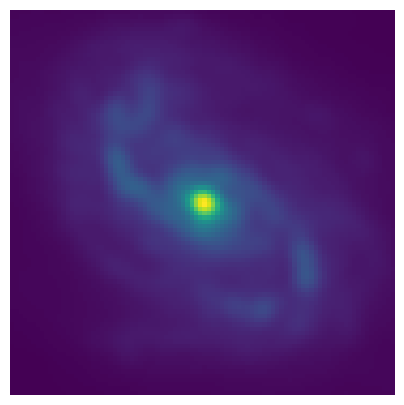

In [1]:
import astropy
from astropy.io import fits
import matplotlib.pyplot as plt
import numpy as np

path = "/Users/ruby/Documents/Python Scripts/Filters/HighRes/"
hdu = fits.open(path+"F115W/30.fits")[0]
data_img = hdu.data


fig = plt.figure(figsize=(12,5))
plt.imshow(data_img)
plt.axis("off")
plt.show()

We call the Ellipse method and use $\sigma$-clipping.

In [2]:
from photutils.isophote import Ellipse
ellipse = Ellipse(data_img)
isophote_list = ellipse.fit_image(sclip=2., nclip=3)

Now, we can build our image model.

Note that we use a background estimate taken from the data array itself which works *ok* for this particular example.

In [3]:
from photutils.isophote import build_ellipse_model

model_img = build_ellipse_model(data_img.shape, isophote_list, fill=np.mean(data_img[0:10, 0:10]))

Now we can display the modelled central region:

Text(0.5, 1.0, 'Data')

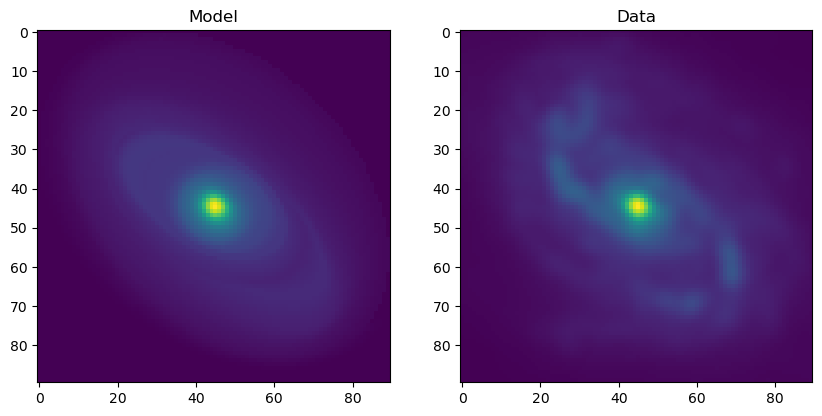

In [4]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 10))

ax1.imshow(model_img)
ax1.set_title("Model")

ax2.imshow(data_img)
ax2.set_title("Data")

Finally, we get a residual image by subtracting the model from the data.

In [5]:
residual = data_img - model_img

Text(0.5, 1.0, 'Residual')

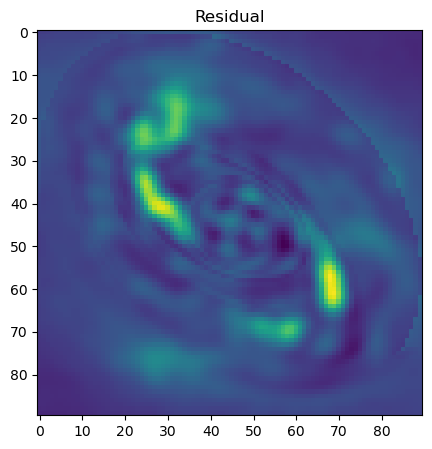

In [6]:
fig, ax = plt.subplots(figsize=(5, 5))
ax.imshow(residual)
ax.set_title("Residual")

### Elliptical Galaxy Test
The spiral galaxy that we have used above is not the best subject to test this procedure on since the non-elliptical contamination is quite significant.
Instead, we will repeat this procedure with an elliptical galaxy from the output of the cGAN.
We repeat the same procedure but this time, passing an EllipseGeometry instance to the Ellipse method since the centre of the galaxy does not coincide with the image frame centre. We also pass initial value guesses for the ellipticity and position angle parameters.

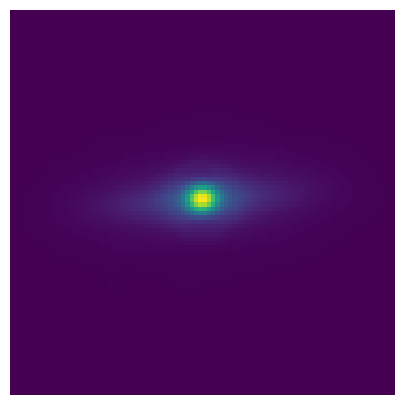

In [7]:
hdu = fits.open(path+"F115W/89.fits")[0]
data = hdu.data
fig = plt.figure(figsize=(12,5))
plt.imshow(data)
plt.axis("off")
plt.show()

In [8]:
from photutils.isophote import Ellipse, EllipseGeometry, build_ellipse_model

g = EllipseGeometry(530., 511, 10., 0.1, 10./180.*np.pi) # geometry to pass to Ellipse method
g.find_center(data)
ellipse = Ellipse(data, geometry=g)
isolist = ellipse.fit_image()

INFO: Found center at x0 =  45.0, y0 =  44.0 [photutils.isophote.geometry]


Again, we build the model and compute the residual.

In [9]:
fill = np.mean(data[20:120, 20:120])
model_image = build_ellipse_model(data.shape, isolist, fill=fill)
residual = data - model_image

Now we can plot the model vs. the data along with the residual.
We can also overlay the isophotes on top of the residual image.

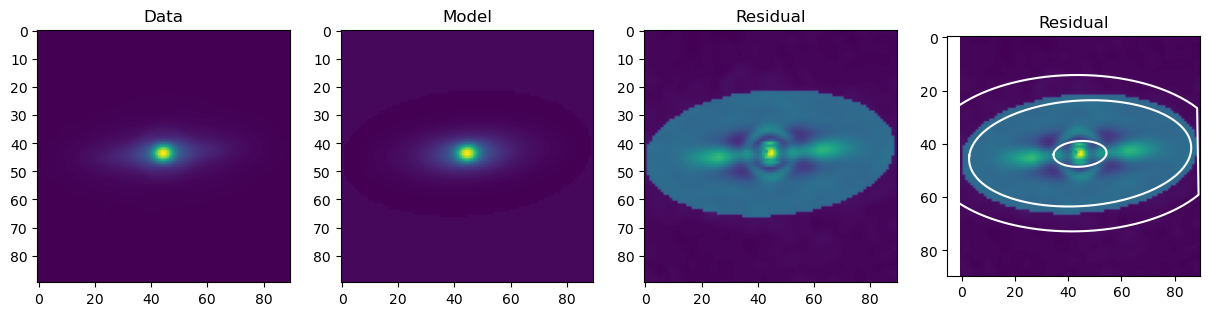

In [10]:
fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(15, 10))
ax1.imshow(data)
ax1.set_title('Data')
ax2.imshow(model_image)
ax2.set_title('Model')
ax3.imshow(residual)
ax3.set_title('Residual')
ax4.imshow(residual)
ax4.set_title('Residual')

# overplot a few isophotes on the residual map
iso1 = isolist.get_closest(10.)
iso2 = isolist.get_closest(40.)
iso3 = isolist.get_closest(100.)

x, y = iso1.sampled_coordinates()
plt.plot(x, y, color='white')
x, y = iso2.sampled_coordinates()
plt.plot(x, y, color='white')
x, y = iso3.sampled_coordinates()
plt.plot(x, y, color='white')

Out of curiosity, we can see how the radial profile looks:

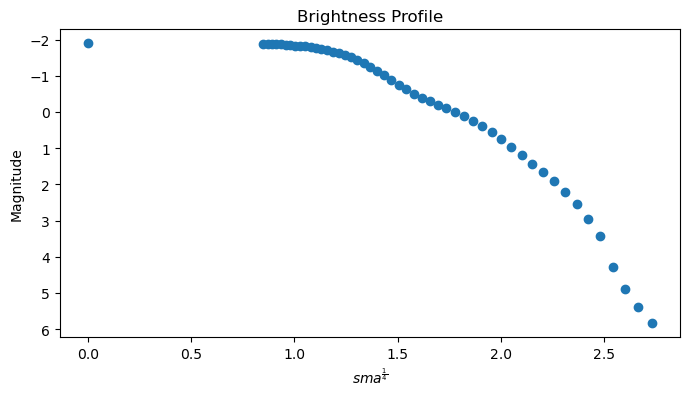

In [11]:
plt.figure(figsize=(8, 4))

plt.scatter(isolist.sma**0.25, -2.5*np.log10(isolist.intens))
plt.title('Brightness Profile')
plt.xlabel(r'$sma^{\frac{1}{4}}$')
plt.ylabel('Magnitude')
plt.gca().invert_yaxis()

and other parameters:

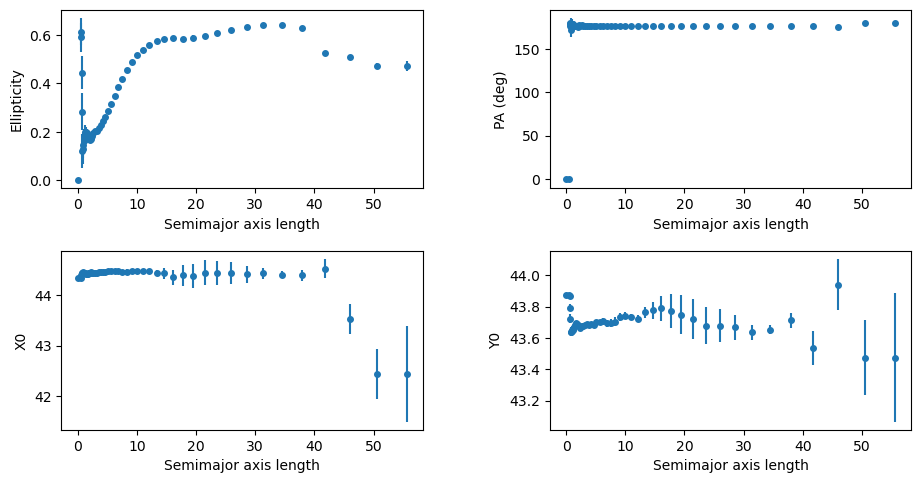

In [12]:
plt.figure(figsize=(10, 5))
plt.figure(1)

plt.subplot(221)
plt.errorbar(isolist.sma, isolist.eps, yerr=isolist.ellip_err, fmt='o', markersize=4)
plt.xlabel('Semimajor axis length')
plt.ylabel('Ellipticity')

plt.subplot(222)
plt.errorbar(isolist.sma, isolist.pa/np.pi*180., yerr=isolist.pa_err/np.pi*80., fmt='o', markersize=4)
plt.xlabel('Semimajor axis length')
plt.ylabel('PA (deg)')

plt.subplot(223)
plt.errorbar(isolist.sma, isolist.x0, yerr=isolist.x0_err, fmt='o', markersize=4)
plt.xlabel('Semimajor axis length')
plt.ylabel('X0')

plt.subplot(224)
plt.errorbar(isolist.sma, isolist.y0, yerr=isolist.y0_err, fmt='o', markersize=4)
plt.xlabel('Semimajor axis length')
plt.ylabel('Y0')

plt.subplots_adjust(top=0.92, bottom=0.08, left=0.10, right=0.95, hspace=0.35, wspace=0.35)

Again, we will plot the higher order hamonics:

<Figure size 1000x500 with 0 Axes>

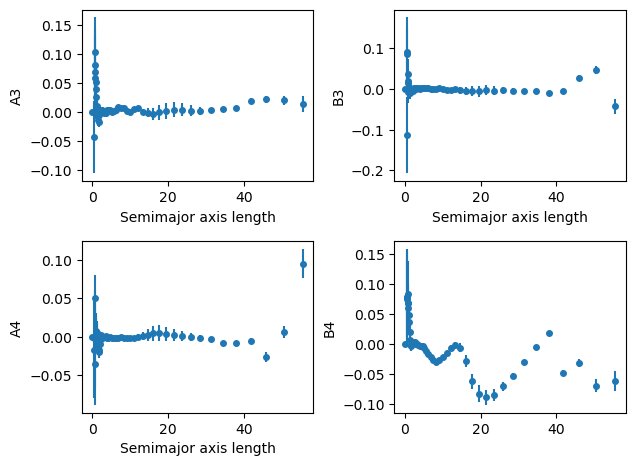

In [13]:
plt.figure(figsize=(10, 5))
plt.figure(2)

plt.subplot(221)
plt.errorbar(isolist.sma, isolist.a3, yerr=isolist.a3_err, fmt='o', markersize=4)
plt.xlabel('Semimajor axis length')
plt.ylabel('A3')

plt.subplot(222)
plt.errorbar(isolist.sma, isolist.b3, yerr=isolist.b3_err, fmt='o', markersize=4)
plt.xlabel('Semimajor axis length')
plt.ylabel('B3')

plt.subplot(223)
plt.errorbar(isolist.sma, isolist.a4, yerr=isolist.a4_err, fmt='o', markersize=4)
plt.xlabel('Semimajor axis length')
plt.ylabel('A4')

plt.subplot(224)
plt.errorbar(isolist.sma, isolist.b4, yerr=isolist.b4_err, fmt='o', markersize=4)
plt.xlabel=('Semimajor axis length')
plt.ylabel('B4')

plt.subplots_adjust(top=0.92, bottom=0.08, left=0.10, right=0.95, hspace=0.35, wspace=0.35)

Note how the parameter $B4$ is negative for a semi-major axis length of $\sim 20$ pixels suggesting that this geometry makes the galaxy appear boxy.

Let's repeat this procedure with $\sigma$-clipping and see how it affects the residual.
Note that we do not have to create another Ellipse instance since nothing has changed in either the input pixel map or the input ellipse geometry.

In [14]:
isolist_2 = ellipse.fit_image(sclip=3., nclip=3)

fill = np.mean(data_img[20:120, 20:120])
model_img_2 = build_ellipse_model(data_img.shape, isolist_2, fill=fill)
residual_2 = data_img - model_img_2

We can plot the residuals using a narrow range for the pixel values.

Text(0.5, 1.0, 'Residual without Sigma-Clipping')

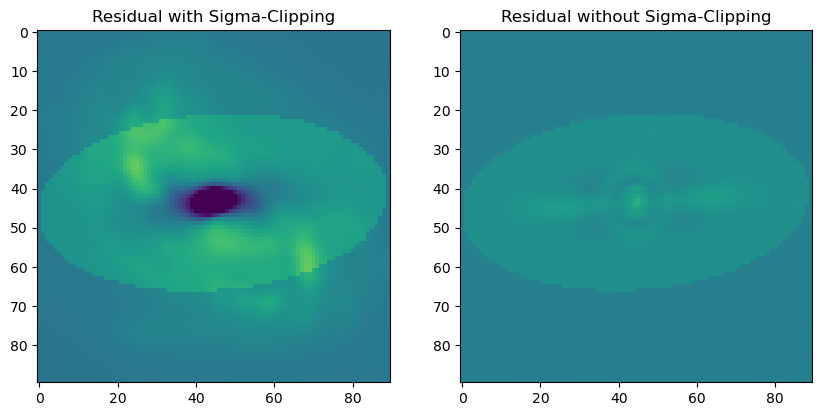

In [15]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 10))

ax1.imshow(residual_2, vmin=-1, vmax=1)
ax1.set_title('Residual with Sigma-Clipping')

ax2.imshow(residual, vmin=-1, vmax=1)
ax2.set_title('Residual without Sigma-Clipping')